In [97]:
!pip install seaborn

In [3]:
!pip install yfinance

  Using cached yfinance-0.2.65-py2.py3-none-any.whl.metadata (5.8 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 4.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached yfinance-0.2.65-py2.py3-none-any.whl (119 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 4.5 MB/s eta 0:00:00a 0:00:01
  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for multitasking: filename=multitask

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import requests


In [124]:
avg_loan = 25000000
num_loans = 15
sofr_spread = .05

np.random.seed(42)
portfolio = pd.DataFrame({
    'loan_id': range(1, num_loans + 1 ),
    'amount': np.random.lognormal(mean=np.log(avg_loan), sigma=.05, size= num_loans),
    'ltv': np.random.uniform(0.5, 0.8, size=num_loans),
    'probd': np.random.uniform(0.01, 0.10, size=num_loans)  
})


In [132]:
try:
    sofr_rates = pd.read_csv("sofr.csv", parse_dates=['Effective Date'], index_col='Effective Date')['Rate (%)'] / 100
    sofr_rates = sofr_rates.dropna()
    assert len(sofr_rates) > 0, "Data is empty after loading!"
except Exception as e:
    raise ValueError(f"Failed to load SOFR data: {e}")

# 2. Calculate returns and parameters
sofr_returns = np.log(sofr_rates / sofr_rates.shift(1)).dropna()
mu_sofr = sofr_returns.mean() * 252
sigma_sofr = sofr_returns.std() * np.sqrt(252)

# 3. Simulation function
def simulate_sofr_paths(initial_rate, mu, sigma, days=252, n_simulations=1000):
    dt = 1/days
    paths = np.zeros((days, n_simulations))
    paths[0] = initial_rate
    
    for t in range(1, days):
        shocks = np.random.normal(0, 1, n_simulations)
        paths[t] = paths[t-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*shocks)
    return paths

# 4. Run simulation
initial_sofr = float(sofr_rates.iloc[-1])  # Explicit conversion to float
new_sofr_paths = simulate_sofr_paths(initial_sofr, mu_sofr, sigma_sofr)
print("Simulation successful!")

Simulation successful!


In [146]:
n_simulations = 1000
recovery_rate = 0.85
losses = np.zeros(n_simulations)

for i in range(n_simulations):
    sofr_horizon = new_sofr_paths[-1, i]
    avg_sofr_per_sim[i] = np.mean(new_sofr_paths[:, i])  # Track average SOFR
    
    # Dynamic risk adjustments
    probd_adjusted = portfolio['probd'] * (1 + 2*(sofr_horizon - initial_sofr)/initial_sofr)
    probd_adjusted = np.clip(probd_adjusted, 0.01, 0.30)
    
    ltv_adjusted = portfolio['ltv'] * (1 + 0.1*(sofr_horizon - initial_sofr)/initial_sofr)
    
    defaults = np.random.binomial(1, probd_adjusted, size=num_loans)
    losses[i] = np.sum(portfolio['amount'] * (1-recovery_rate) * defaults * (ltv_adjusted > 0.8))
    
    

In [148]:
var_95 = np.percentile(losses, 95)
expected_loss = np.mean(losses)

print(f" Expected Annual Loss: {expected_loss:,.3f}")


 Expected Annual Loss: 423,182.798


In [150]:
print("SOFR stats:", np.mean(new_sofr_paths), np.std(new_sofr_paths))  
print("Loss stats:", np.mean(losses), np.std(losses))  

SOFR stats: 0.012616016101024313 0.045344331174055064
Loss stats: 423182.7977072745 2527714.406263487


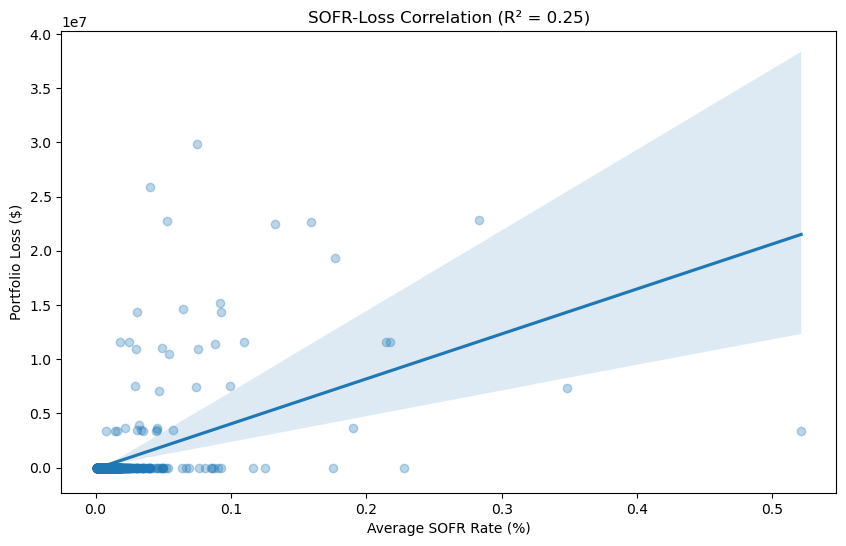

In [154]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(x=avg_sofr_per_sim, y=losses, scatter_kws={'alpha':0.3})
plt.title(f"SOFR-Loss Correlation (R² = {stats.linregress(avg_sofr_per_sim, losses)[2]**2:.2f})")
plt.xlabel("Average SOFR Rate (%)")
plt.ylabel("Portfolio Loss ($)")
plt.show()